In [1]:
import sys
sys.path
sys.executable
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
!conda info


     active environment : tf_gpu_2.2
    active env location : /media/ubuntu/MyHDataStor1/anaconda2/envs/tf_gpu_2.2
            shell level : 1
       user config file : /home/ubuntu/.condarc
 populated config files : 
          conda version : 4.7.12
    conda-build version : 3.18.9
         python version : 2.7.16.final.0
       virtual packages : __cuda=10.2
       base environment : /media/ubuntu/MyHDataStor1/anaconda2  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /media/ubuntu/MyHDataStor1/anaconda2/pkgs
                          /home/ubuntu/.conda/pkgs
       envs directories : /media/ubuntu/MyHDataStor1/anaconda2/envs
                          /home/ubuntu/.conda/envs
               platform : linux-64
             

In [3]:
!which python 


/media/ubuntu/MyHDataStor1/anaconda2/envs/tf_gpu_2.2/bin/python


In [4]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, \
    MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from data_utils import *

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [5]:
class UNet(object):
    def __init__(self, img_shape, num_of_class, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)


        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate),
                          loss = 'binary_crossentropy', metrics = [dice_coef])

        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        
        earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
        checkpoint = ModelCheckpoint('checkpoint/model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min')  
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

        
        self.history = self.model.fit(X_train, Y_train, callbacks=[earlystopping,checkpoint,reduce_lr_loss ], validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes

    # show u-net architecture
    def show_model(self):
        return print(self.model.summary())



# Load Data

In [49]:
x_train = np.load('./dataset/x_train_512.npy')
y_train = np.load('./dataset/y_train_512.npy')
x_test = np.load('./dataset/x_test_512.npy')
y_test = np.load('./dataset/y_test_512.npy')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(966, 512, 512, 1) (966, 512, 512, 1)
(51, 512, 512, 1) (51, 512, 512, 1)


# Segmentation Class U-Net

In [8]:
seg_model = UNet(img_shape = (512,512,1), num_of_class = 1,learning_rate = 1e-5, do_drop = True, drop_rate = 0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
seg_model.show_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_2[0][0]                   
______________________________________________________________________________________________

# Train Model

In [65]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 4, val_split = 0.1)

Train on 869 samples, validate on 97 samples
Epoch 1/100
868/869 [============================>.] - ETA: 0s - loss: 0.3508 - dice_coef: 0.3078
Epoch 00001: val_loss improved from inf to 0.19799, saving model to checkpoint/model-001-0.197989.h5
869/869 [==============================] - 135s 156ms/sample - loss: 0.3506 - dice_coef: 0.3092 - val_loss: 0.1980 - val_dice_coef: 0.4679
Epoch 2/100
868/869 [============================>.] - ETA: 0s - loss: 0.1321 - dice_coef: 0.7198
Epoch 00002: val_loss improved from 0.19799 to 0.09575, saving model to checkpoint/model-002-0.095748.h5
869/869 [==============================] - 133s 153ms/sample - loss: 0.1321 - dice_coef: 0.7195 - val_loss: 0.0957 - val_dice_coef: 0.7840
Epoch 3/100
868/869 [============================>.] - ETA: 0s - loss: 0.0862 - dice_coef: 0.8369
Epoch 00003: val_loss improved from 0.09575 to 0.05816, saving model to checkpoint/model-003-0.058160.h5
869/869 [==============================] - 133s 153ms/sample - loss: 0.0

Epoch 27/100
868/869 [============================>.] - ETA: 0s - loss: 0.0203 - dice_coef: 0.9659
Epoch 00027: val_loss did not improve from 0.01886
869/869 [==============================] - 133s 153ms/sample - loss: 0.0203 - dice_coef: 0.9660 - val_loss: 0.0192 - val_dice_coef: 0.9494
Epoch 28/100
868/869 [============================>.] - ETA: 0s - loss: 0.0186 - dice_coef: 0.9692
Epoch 00028: val_loss improved from 0.01886 to 0.01443, saving model to checkpoint/model-028-0.014429.h5
869/869 [==============================] - 134s 155ms/sample - loss: 0.0186 - dice_coef: 0.9692 - val_loss: 0.0144 - val_dice_coef: 0.9703
Epoch 29/100
868/869 [============================>.] - ETA: 0s - loss: 0.0193 - dice_coef: 0.9690
Epoch 00029: val_loss did not improve from 0.01443
869/869 [==============================] - 134s 154ms/sample - loss: 0.0193 - dice_coef: 0.9691 - val_loss: 0.0185 - val_dice_coef: 0.9597
Epoch 30/100
868/869 [============================>.] - ETA: 0s - loss: 0.0180 

869/869 [==============================] - 132s 152ms/sample - loss: 0.0133 - dice_coef: 0.9784 - val_loss: 0.0122 - val_dice_coef: 0.9753
Epoch 54/100
868/869 [============================>.] - ETA: 0s - loss: 0.0132 - dice_coef: 0.9787
Epoch 00054: val_loss improved from 0.01218 to 0.01215, saving model to checkpoint/model-054-0.012151.h5
869/869 [==============================] - 132s 152ms/sample - loss: 0.0132 - dice_coef: 0.9786 - val_loss: 0.0122 - val_dice_coef: 0.9771
Epoch 55/100
868/869 [============================>.] - ETA: 0s - loss: 0.0131 - dice_coef: 0.9781
Epoch 00055: val_loss did not improve from 0.01215
869/869 [==============================] - 131s 151ms/sample - loss: 0.0131 - dice_coef: 0.9780 - val_loss: 0.0123 - val_dice_coef: 0.9766
Epoch 56/100
868/869 [============================>.] - ETA: 0s - loss: 0.0131 - dice_coef: 0.9787
Epoch 00056: val_loss did not improve from 0.01215
869/869 [==============================] - 131s 151ms/sample - loss: 0.0131 - d

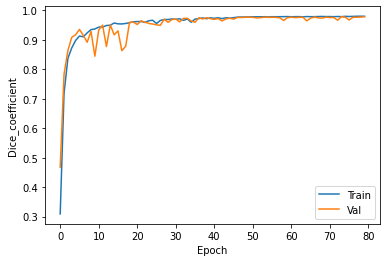

In [66]:
plot_dice(history)

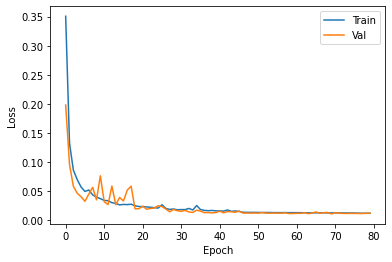

In [67]:
plot_loss(history)

# Show result

In [71]:
print(x_test.shape)
print(x_test[:10,:,:,:].shape)

(51, 512, 512, 1)
(10, 512, 512, 1)


In [89]:
seg_model.model.save('checkpoint/model-last.h5')

In [91]:
seg_model.model = keras.models.load_model('checkpoint/model-last.h5', custom_objects={"dice_coef": dice_coef})

In [10]:
'''
# Option 1: Load with the custom_object argument.
seg_model.model  = keras.models.load_model(
    "checkpoint/model-070-0.010826.h5", custom_objects={"dice_coef": dice_coef}
)
'''

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [93]:
preds1 = seg_model.predict(x_test[:4,:,:,:])
preds2 = seg_model.predict(x_test[4:8,:,:,:])

In [94]:
print(preds1.shape)
print(preds2.shape)
preds = np.concatenate((preds1, preds2), axis=0)

(4, 512, 512, 1)
(4, 512, 512, 1)


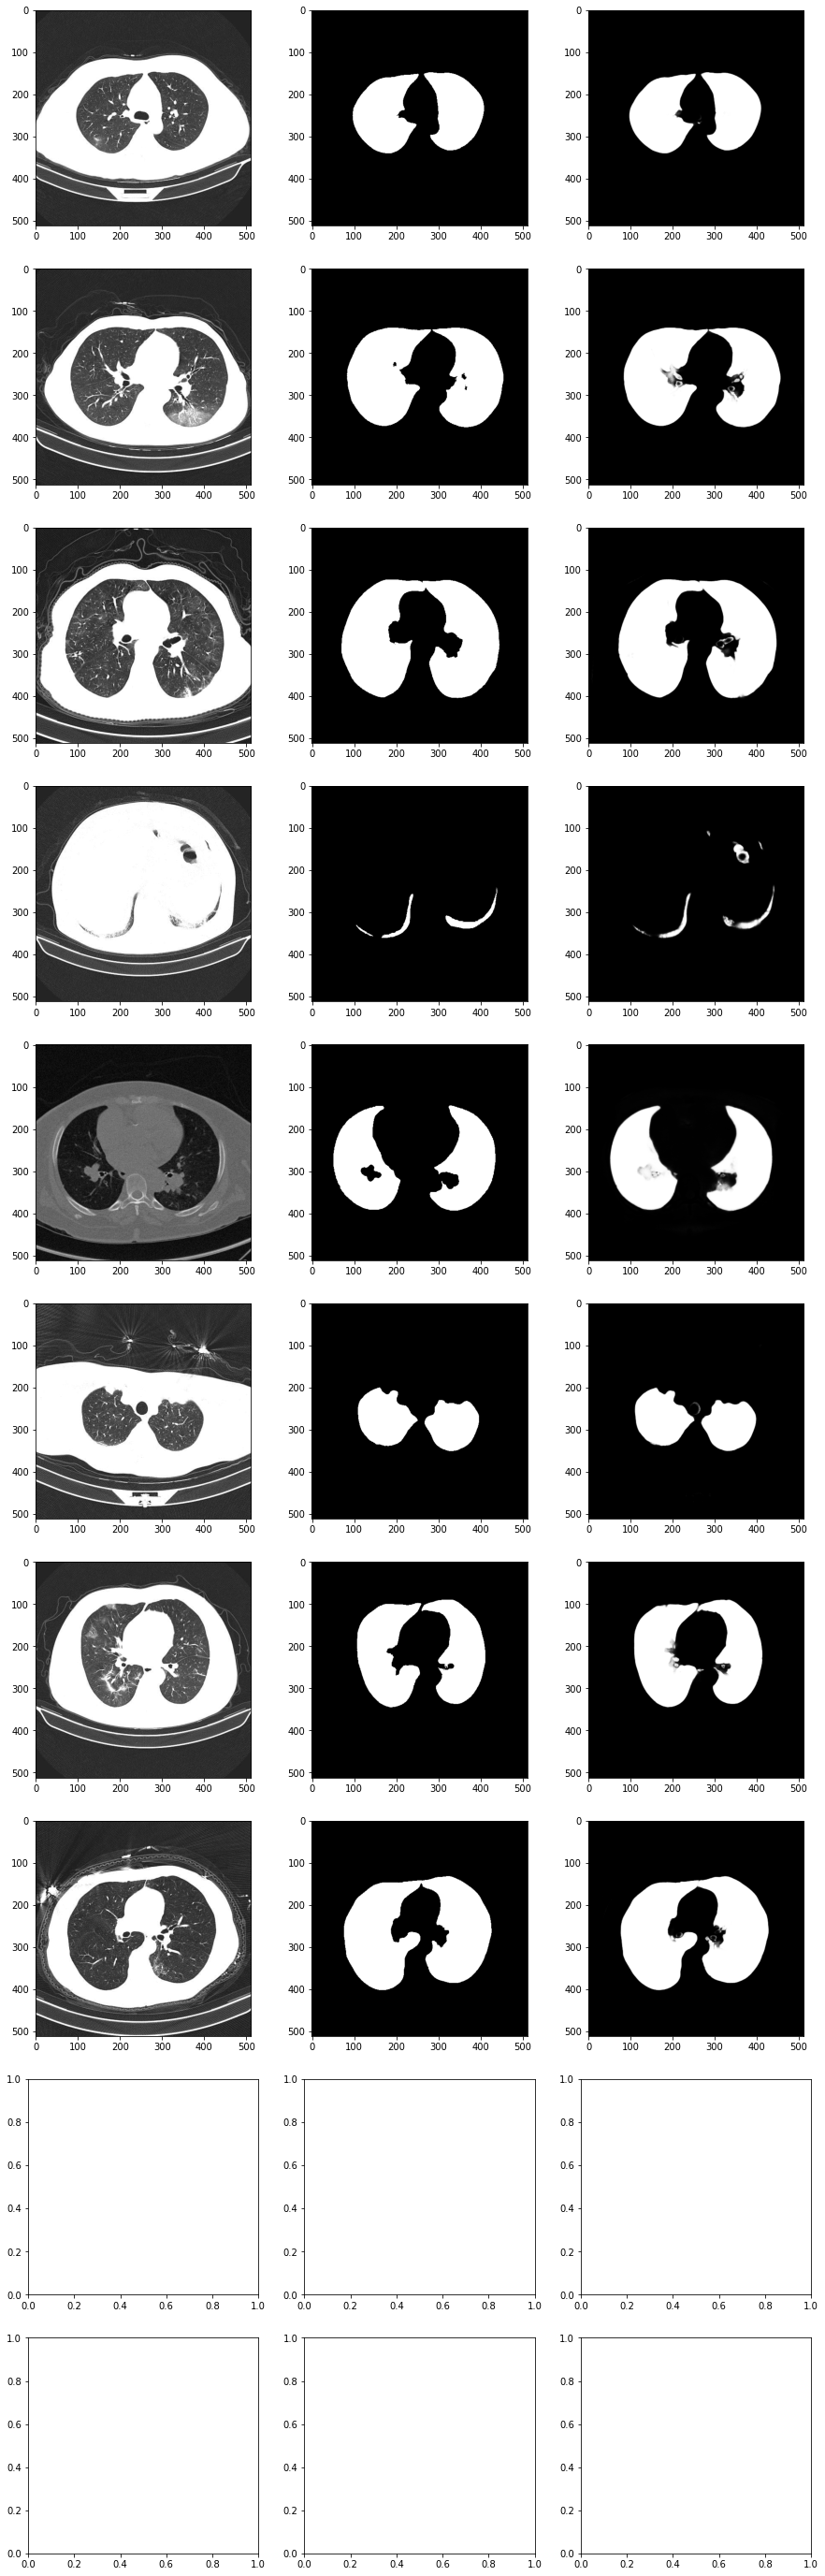

In [95]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

In [19]:
import cv2 

ct_scan_dir = '/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/val/covid/ct_scan_0/'
ct_scan_files = [] 

imgs = [] 
for i in range(150,160):
    fn_full = ct_scan_dir+'{}.jpg'.format(i) 
    img = cv2.imread(fn_full,0) 
    img = np.expand_dims(img,axis=2)
    imgs.append(img)
x_test = np.asarray(imgs) 
print(x_test.shape) 

(10, 512, 512, 1)


In [20]:
preds1 = seg_model.predict(x_test[:5,:,:,:])
preds2 = seg_model.predict(x_test[5:10,:,:,:])
print(preds1.shape)
print(preds2.shape)
preds = np.concatenate((preds1, preds2), axis=0)

(5, 512, 512, 1)
(5, 512, 512, 1)


In [22]:
print(np.unique(preds1))

[0.00000000e+00 2.98023224e-08 5.96046448e-08 8.94069672e-08
 1.19209290e-07 1.49011612e-07 1.78813934e-07 2.08616257e-07
 2.38418579e-07 2.68220901e-07 2.98023224e-07 3.27825546e-07
 3.57627869e-07 4.17232513e-07 4.47034836e-07 4.76837158e-07
 5.06639481e-07 5.66244125e-07 5.96046448e-07 6.25848770e-07
 6.55651093e-07 6.85453415e-07 7.45058060e-07 7.74860382e-07
 8.04662704e-07 9.83476639e-07 1.01327896e-06 1.07288361e-06
 1.10268593e-06 1.22189522e-06 1.31130219e-06 1.34110451e-06
 1.37090683e-06 1.49011612e-06 1.51991844e-06 1.75833702e-06
 1.78813934e-06 1.81794167e-06 1.84774399e-06 2.11596489e-06
 2.38418579e-06 2.50339508e-06 2.56299973e-06 2.59280205e-06
 2.65240669e-06 2.86102295e-06 3.60608101e-06 3.78489494e-06
 3.90410423e-06 3.96370888e-06 4.29153442e-06 4.38094139e-06
 4.50015068e-06 4.79817390e-06 5.00679016e-06 5.06639481e-06
 5.09619713e-06 5.36441803e-06 5.39422035e-06 5.51342964e-06
 5.54323196e-06 5.78165054e-06 6.31809235e-06 6.37769699e-06
 6.55651093e-06 6.645917

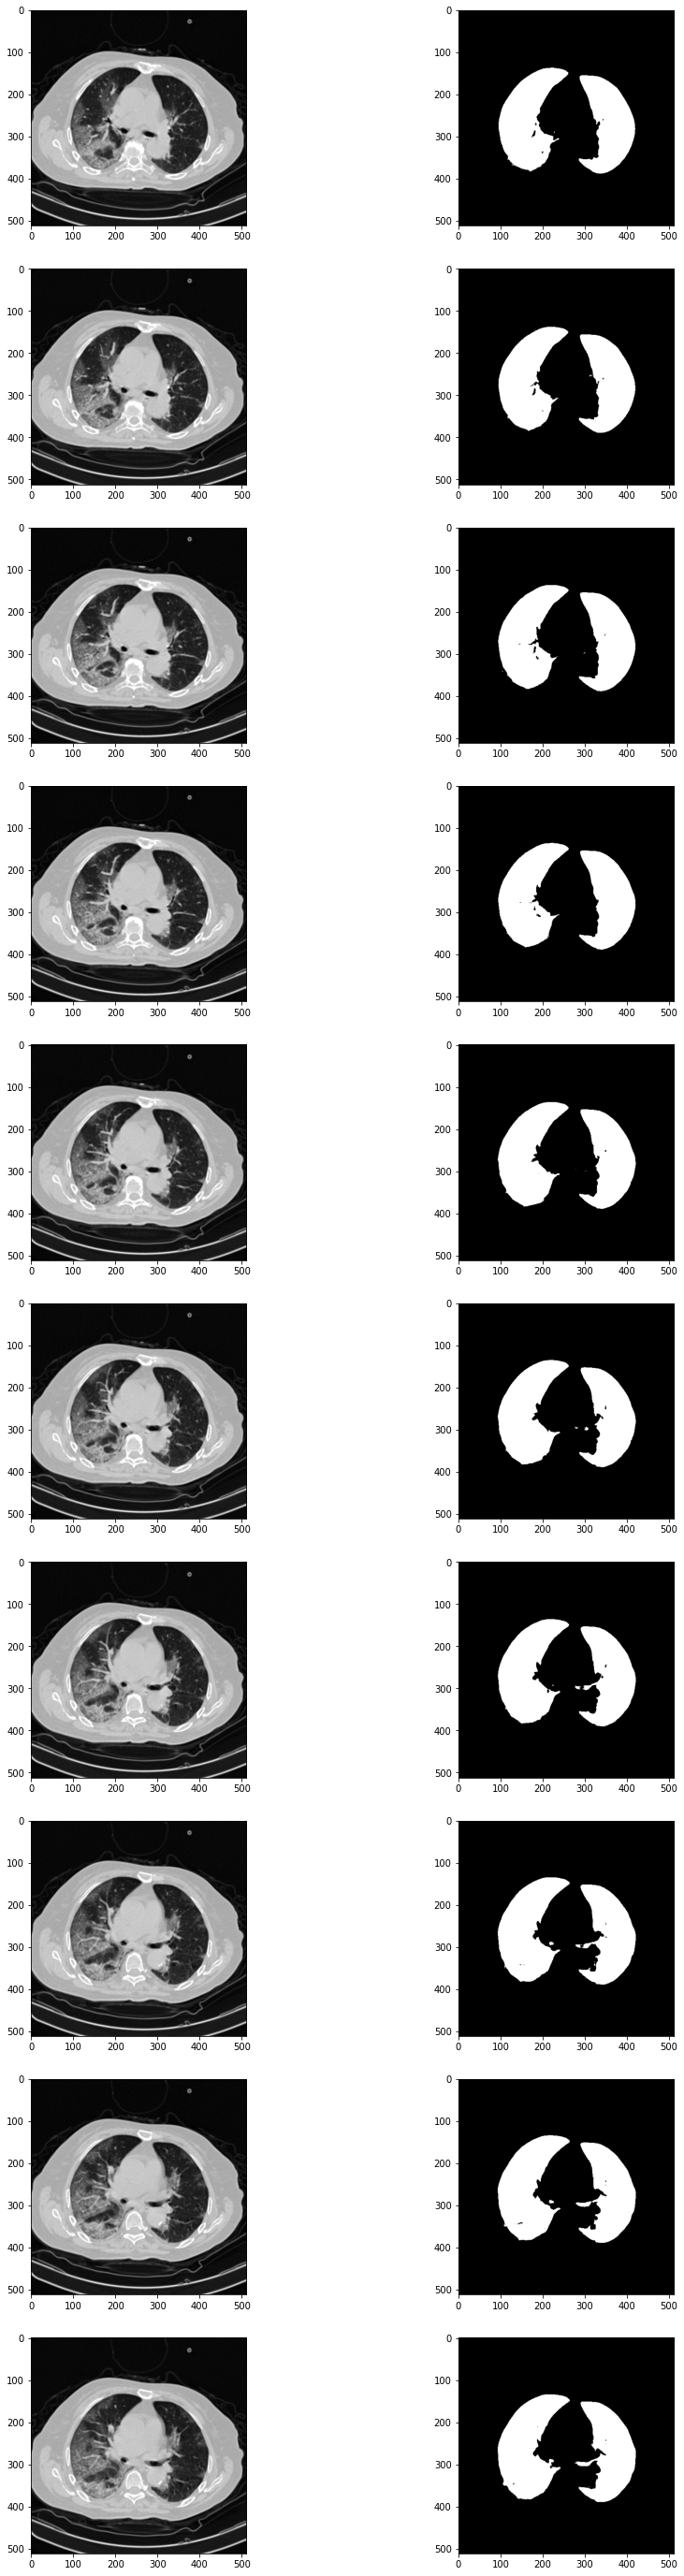

In [21]:
show_num = 10
fig, ax = plt.subplots(show_num, 2, figsize=(15, 50))
for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')    
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [23]:
covidx_dir = '/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/'
covidx_img_dir= covidx_dir 
covidx_img_dir_cropped = covidx_dir + 'mask/'

if not os.path.exists(covidx_img_dir_cropped):
    os.makedirs(covidx_img_dir_cropped)
print(covidx_dir)
print(covidx_img_dir)
print(covidx_img_dir_cropped)


/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/
/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/
/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/mask/


In [36]:
#subsets = ['test'] # ,'val','train']
subsets = ['val','train']

from tqdm import tqdm

debug = False 

for subset in subsets:     
    
    cls = ['covid','non-covid'] 
        
    for c in cls: 
        cls_path = os.listdir(covidx_img_dir+"{}/{}/".format(subset,c))
        num_scans = len(cls_path) 
        
        
        pbar = tqdm(total=num_scans)
        
        
        
        for ind in range(num_scans):            
            
            pbar.update()
            
            
            s = "ct_scan_{}".format(ind)
            s_path = "{}/{}/{}".format(subset,c,s)
            #print(s_path)
            
            sfiles = os.listdir(covidx_img_dir+s_path) 
            sfiles = [x for x in sfiles if not x.startswith('.')]
            sfiles.sort(key = lambda x: int(x.split('.')[0]))
            
            
            fout_dir  = covidx_img_dir_cropped+"{}/{}/{}".format(subset,c,s)                   
            #print(fout_dir)
            
            if not os.path.exists(fout_dir):
                os.makedirs(fout_dir)

            count = 0     

            for f in sfiles:
                
                count += 1 
                
                fn = "{}/{}/{}/{}".format(subset,c,s,f)                
                f_full = covidx_img_dir + fn  
                fout_full = covidx_img_dir_cropped + fn                   
                if os.path.exists(fout_full):
                    continue 
                
                img = cv2.imread(f_full, cv2.IMREAD_UNCHANGED)
                if img.shape != (512,512):
                    img = cv2.resize(img,(512,512)) 
                                
                img = np.expand_dims(img,axis=2)
                img = np.expand_dims(img,axis=0)
                
                mask = seg_model.predict(img)
                
                
                mask = mask.squeeze()
                #print(mask.shape)
                
                mask = ((mask > 0.5)*255).astype(np.uint8) 
                
                fout_full = covidx_img_dir_cropped + fn    
                #print(fout_full)
                
                if debug: 
                    fig, (ax1,ax2) = plt.subplots(1,2)
                    ax1.imshow(img.squeeze(),cmap='gray')
                    ax2.imshow(mask.squeeze(),cmap='gray')

                if not os.path.exists(fout_full):
                    #print("writing image")
                    cv2.imwrite(fout_full,mask)
                #if count>5:
                #    break 
            #break 
                
        #break 
                














  0%|          | 0/165 [00:00<?, ?it/s]










 12%|█▏        | 20/165 [00:00<00:01, 114.27it/s]










 12%|█▏        | 20/165 [00:15<00:01, 114.27it/s]










 13%|█▎        | 21/165 [00:36<26:01, 10.84s/it] 










 13%|█▎        | 22/165 [00:42<22:26,  9.42s/it]










 14%|█▍        | 23/165 [01:17<40:30, 17.12s/it]










 15%|█▍        | 24/165 [01:23<32:17, 13.74s/it]










 15%|█▌        | 25/165 [01:29<26:55, 11.54s/it]










 16%|█▌        | 26/165 [01:36<23:22, 10.09s/it]










 16%|█▋        | 27/165 [02:13<42:00, 18.26s/it]










 17%|█▋        | 28/165 [02:58<59:40, 26.14s/it]










 18%|█▊        | 29/165 [03:03<44:55, 19.82s/it]










 18%|█▊        | 30/165 [03:39<55:37, 24.72s/it]










 19%|█▉        | 31/165 [04:19<1:05:06, 29.15s/it]










 19%|█▉        | 32/165 [04:59<1:11:50, 32.41s/it]










 20%|██        | 33/165 [05:05<53:53, 24.49s/it]  










 21%|██        | 34/165 [05:48<1:05:51, 30.16

 13%|█▎        | 27/209 [13:46<2:00:45, 39.81s/it]











 13%|█▎        | 28/209 [14:29<2:02:58, 40.76s/it]











 14%|█▍        | 29/209 [15:14<2:06:24, 42.13s/it]











 14%|█▍        | 30/209 [15:48<1:58:16, 39.65s/it]











 15%|█▍        | 31/209 [16:24<1:54:01, 38.44s/it]











 15%|█▌        | 32/209 [16:56<1:47:40, 36.50s/it]











 16%|█▌        | 33/209 [17:42<1:55:27, 39.36s/it]











 16%|█▋        | 34/209 [17:49<1:26:32, 29.67s/it]











 17%|█▋        | 35/209 [18:28<1:34:46, 32.68s/it]











 17%|█▋        | 36/209 [19:16<1:47:05, 37.14s/it]











 18%|█▊        | 37/209 [20:06<1:57:26, 40.97s/it]











 18%|█▊        | 38/209 [20:42<1:52:22, 39.43s/it]











 19%|█▊        | 39/209 [21:25<1:54:39, 40.47s/it]











 19%|█▉        | 40/209 [21:31<1:24:59, 30.18s/it]











 20%|█▉        | 41/209 [21:39<1:05:59, 23.57s/it]











 20%|██        | 42/209 [21:46<51:28, 18.49s/it]  











 21%|██ 

 93%|█████████▎| 194/209 [1:10:29<04:21, 17.46s/it]











 93%|█████████▎| 195/209 [1:10:40<03:37, 15.52s/it]











 94%|█████████▍| 196/209 [1:10:51<03:04, 14.21s/it]











 94%|█████████▍| 197/209 [1:10:57<02:20, 11.72s/it]











 95%|█████████▍| 198/209 [1:11:06<01:59, 10.90s/it]











 95%|█████████▌| 199/209 [1:11:39<02:54, 17.41s/it]











 96%|█████████▌| 200/209 [1:11:49<02:15, 15.08s/it]











 96%|█████████▌| 201/209 [1:12:17<02:31, 18.93s/it]











 97%|█████████▋| 202/209 [1:12:26<01:53, 16.22s/it]











 97%|█████████▋| 203/209 [1:12:32<01:18, 13.14s/it]











 98%|█████████▊| 204/209 [1:13:06<01:37, 19.40s/it]











 98%|█████████▊| 205/209 [1:13:16<01:05, 16.48s/it]











 99%|█████████▊| 206/209 [1:13:24<00:41, 13.98s/it]











 99%|█████████▉| 207/209 [1:13:29<00:22, 11.32s/it]











100%|█████████▉| 208/209 [1:13:39<00:10, 10.79s/it]











100%|██████████| 209/209 [1:13:47<00:00,  9.86s/it]





 10%|▉         | 66/687 [25:48<3:23:50, 19.69s/it]












 10%|▉         | 67/687 [25:53<2:39:19, 15.42s/it]












 10%|▉         | 68/687 [25:59<2:08:18, 12.44s/it]












 10%|█         | 69/687 [26:34<3:16:57, 19.12s/it]












 10%|█         | 70/687 [26:40<2:38:35, 15.42s/it]












 10%|█         | 71/687 [26:46<2:09:19, 12.60s/it]












 10%|█         | 72/687 [26:52<1:48:31, 10.59s/it]












 11%|█         | 73/687 [27:30<3:11:25, 18.71s/it]












 11%|█         | 74/687 [27:36<2:32:56, 14.97s/it]












 11%|█         | 75/687 [28:24<4:14:30, 24.95s/it]












 11%|█         | 76/687 [28:29<3:13:16, 18.98s/it]












 11%|█         | 77/687 [28:59<3:44:39, 22.10s/it]












 11%|█▏        | 78/687 [29:37<4:33:24, 26.94s/it]












 11%|█▏        | 79/687 [30:29<5:48:55, 34.43s/it]












 12%|█▏        | 80/687 [31:12<6:15:19, 37.10s/it]












 12%|█▏        | 81/687 [32:07<7:08:53, 42.46s/it]






 32%|███▏      | 223/687 [1:39:11<3:23:28, 26.31s/it]












 33%|███▎      | 224/687 [1:39:17<2:37:03, 20.35s/it]












 33%|███▎      | 225/687 [1:39:21<1:58:56, 15.45s/it]












 33%|███▎      | 226/687 [1:39:27<1:36:45, 12.59s/it]












 33%|███▎      | 227/687 [1:40:27<3:26:32, 26.94s/it]












 33%|███▎      | 228/687 [1:40:33<2:37:23, 20.57s/it]












 33%|███▎      | 229/687 [1:41:14<3:24:14, 26.76s/it]












 33%|███▎      | 230/687 [1:41:57<3:59:23, 31.43s/it]












 34%|███▎      | 231/687 [1:42:02<2:59:56, 23.68s/it]












 34%|███▍      | 232/687 [1:42:36<3:23:18, 26.81s/it]












 34%|███▍      | 233/687 [1:43:18<3:55:51, 31.17s/it]












 34%|███▍      | 234/687 [1:43:52<4:01:23, 31.97s/it]












 34%|███▍      | 235/687 [1:44:26<4:05:44, 32.62s/it]












 34%|███▍      | 236/687 [1:45:06<4:22:28, 34.92s/it]












 34%|███▍      | 237/687 [1:45:54<4:50:48, 38.77s/it]












 35%|███▍ 

 55%|█████▌    | 379/687 [2:53:33<2:09:59, 25.32s/it]












 55%|█████▌    | 380/687 [2:54:11<2:29:46, 29.27s/it]












 55%|█████▌    | 381/687 [2:54:54<2:49:19, 33.20s/it]












 56%|█████▌    | 382/687 [2:55:39<3:07:55, 36.97s/it]












 56%|█████▌    | 383/687 [2:56:14<3:03:14, 36.17s/it]












 56%|█████▌    | 384/687 [2:56:20<2:17:42, 27.27s/it]












 56%|█████▌    | 385/687 [2:56:57<2:32:03, 30.21s/it]












 56%|█████▌    | 386/687 [2:57:40<2:50:02, 33.89s/it]












 56%|█████▋    | 387/687 [2:58:16<2:53:41, 34.74s/it]












 56%|█████▋    | 388/687 [2:58:59<3:04:29, 37.02s/it]












 57%|█████▋    | 389/687 [2:59:36<3:04:08, 37.08s/it]












 57%|█████▋    | 390/687 [3:00:21<3:14:34, 39.31s/it]












 57%|█████▋    | 391/687 [3:00:58<3:10:51, 38.69s/it]












 57%|█████▋    | 392/687 [3:01:32<3:04:05, 37.44s/it]












 57%|█████▋    | 393/687 [3:02:18<3:15:05, 39.81s/it]












 57%|█████

 78%|███████▊  | 535/687 [3:52:21<26:58, 10.65s/it]












 78%|███████▊  | 536/687 [3:52:27<23:12,  9.22s/it]












 78%|███████▊  | 537/687 [3:53:07<45:51, 18.34s/it]












 78%|███████▊  | 538/687 [3:53:18<40:15, 16.21s/it]












 78%|███████▊  | 539/687 [3:53:32<38:02, 15.42s/it]












 79%|███████▊  | 540/687 [3:54:14<57:19, 23.40s/it]












 79%|███████▊  | 541/687 [3:54:25<48:00, 19.73s/it]












 79%|███████▉  | 542/687 [3:55:01<59:43, 24.71s/it]












 79%|███████▉  | 543/687 [3:55:31<1:02:53, 26.20s/it]












 79%|███████▉  | 544/687 [3:56:13<1:13:49, 30.97s/it]












 79%|███████▉  | 545/687 [3:56:40<1:10:03, 29.60s/it]












 79%|███████▉  | 546/687 [3:56:50<56:00, 23.83s/it]  












 80%|███████▉  | 547/687 [3:57:25<1:03:12, 27.09s/it]












 80%|███████▉  | 548/687 [3:57:54<1:04:09, 27.69s/it]












 80%|███████▉  | 549/687 [3:58:00<48:58, 21.30s/it]  












 80%|████████  | 550/687 [

  1%|          | 6/865 [02:57<7:39:32, 32.10s/it]













  1%|          | 7/865 [03:55<9:29:35, 39.83s/it]













  1%|          | 8/865 [04:01<7:00:59, 29.47s/it]













  1%|          | 9/865 [04:38<7:36:19, 31.99s/it]













  1%|          | 10/865 [04:44<5:44:00, 24.14s/it]













  1%|▏         | 11/865 [05:17<6:19:06, 26.64s/it]













  1%|▏         | 12/865 [05:23<4:52:30, 20.57s/it]













  2%|▏         | 13/865 [06:04<6:20:03, 26.76s/it]













  2%|▏         | 14/865 [06:59<8:18:35, 35.15s/it]













  2%|▏         | 15/865 [07:18<7:08:56, 30.28s/it]













  2%|▏         | 16/865 [08:00<7:58:38, 33.83s/it]













  2%|▏         | 17/865 [08:53<9:18:52, 39.54s/it]













  2%|▏         | 18/865 [08:59<6:57:34, 29.58s/it]













  2%|▏         | 19/865 [09:07<5:25:28, 23.08s/it]













  2%|▏         | 20/865 [09:44<6:21:52, 27.12s/it]













  2%|▏         | 21/865 [09:56<5:17:05, 22.5

 18%|█▊        | 159/865 [1:10:04<3:15:49, 16.64s/it]













 18%|█▊        | 160/865 [1:10:05<2:22:38, 12.14s/it]













 19%|█▊        | 161/865 [1:10:42<3:48:08, 19.44s/it]













 19%|█▊        | 162/865 [1:10:48<3:02:46, 15.60s/it]













 19%|█▉        | 163/865 [1:11:48<5:35:31, 28.68s/it]













 19%|█▉        | 164/865 [1:11:54<4:16:45, 21.98s/it]













 19%|█▉        | 165/865 [1:12:46<6:01:32, 30.99s/it]













 19%|█▉        | 166/865 [1:13:22<6:19:50, 32.60s/it]













 19%|█▉        | 167/865 [1:13:37<5:17:27, 27.29s/it]













 19%|█▉        | 168/865 [1:14:38<7:14:02, 37.36s/it]













 20%|█▉        | 169/865 [1:14:44<5:23:09, 27.86s/it]













 20%|█▉        | 170/865 [1:14:49<4:04:04, 21.07s/it]













 20%|█▉        | 171/865 [1:14:55<3:11:48, 16.58s/it]













 20%|█▉        | 172/865 [1:15:01<2:34:45, 13.40s/it]













 20%|██        | 173/865 [1:15:07<2:07:31, 11.06s/it]










 36%|███▌      | 309/865 [2:20:46<7:08:52, 46.28s/it]













 36%|███▌      | 310/865 [2:21:32<7:07:48, 46.25s/it]













 36%|███▌      | 311/865 [2:21:37<5:13:11, 33.92s/it]













 36%|███▌      | 312/865 [2:22:16<5:24:31, 35.21s/it]













 36%|███▌      | 313/865 [2:22:22<4:05:38, 26.70s/it]













 36%|███▋      | 314/865 [2:22:29<3:10:08, 20.70s/it]













 36%|███▋      | 315/865 [2:22:34<2:25:49, 15.91s/it]













 37%|███▋      | 316/865 [2:23:27<4:07:06, 27.01s/it]













 37%|███▋      | 317/865 [2:24:10<4:51:02, 31.87s/it]













 37%|███▋      | 318/865 [2:24:46<5:02:26, 33.17s/it]













 37%|███▋      | 319/865 [2:25:24<5:15:46, 34.70s/it]













 37%|███▋      | 320/865 [2:25:32<4:01:00, 26.53s/it]













 37%|███▋      | 321/865 [2:26:05<4:18:51, 28.55s/it]













 37%|███▋      | 322/865 [2:26:56<5:17:31, 35.09s/it]













 37%|███▋      | 323/865 [2:27:02<3:59:05, 26.47s/it]










 53%|█████▎    | 459/865 [3:25:38<2:20:59, 20.84s/it]













 53%|█████▎    | 460/865 [3:25:46<1:55:33, 17.12s/it]













 53%|█████▎    | 461/865 [3:25:57<1:41:27, 15.07s/it]













 53%|█████▎    | 462/865 [3:26:33<2:24:33, 21.52s/it]













 54%|█████▎    | 463/865 [3:26:37<1:48:43, 16.23s/it]













 54%|█████▎    | 464/865 [3:27:02<2:06:24, 18.92s/it]













 54%|█████▍    | 465/865 [3:27:32<2:27:54, 22.19s/it]













 54%|█████▍    | 466/865 [3:27:42<2:02:49, 18.47s/it]













 54%|█████▍    | 467/865 [3:27:52<1:46:03, 15.99s/it]













 54%|█████▍    | 468/865 [3:28:02<1:34:31, 14.29s/it]













 54%|█████▍    | 469/865 [3:28:07<1:14:40, 11.31s/it]













 54%|█████▍    | 470/865 [3:28:46<2:09:59, 19.75s/it]













 54%|█████▍    | 471/865 [3:29:00<1:57:10, 17.84s/it]













 55%|█████▍    | 472/865 [3:29:10<1:42:15, 15.61s/it]













 55%|█████▍    | 473/865 [3:29:14<1:18:32, 12.02s/it]










 70%|███████   | 609/865 [4:13:20<1:10:25, 16.51s/it]













 71%|███████   | 610/865 [4:13:30<1:01:54, 14.57s/it]













 71%|███████   | 611/865 [4:14:08<1:31:17, 21.56s/it]













 71%|███████   | 612/865 [4:14:13<1:10:28, 16.71s/it]













 71%|███████   | 613/865 [4:14:24<1:02:56, 14.99s/it]













 71%|███████   | 614/865 [4:14:57<1:25:10, 20.36s/it]













 71%|███████   | 615/865 [4:15:28<1:38:21, 23.61s/it]













 71%|███████   | 616/865 [4:15:33<1:14:41, 18.00s/it]













 71%|███████▏  | 617/865 [4:15:45<1:06:15, 16.03s/it]













 71%|███████▏  | 618/865 [4:15:56<59:36, 14.48s/it]  













 72%|███████▏  | 619/865 [4:16:26<1:18:24, 19.12s/it]













 72%|███████▏  | 620/865 [4:16:38<1:10:20, 17.23s/it]













 72%|███████▏  | 621/865 [4:17:17<1:35:56, 23.59s/it]













 72%|███████▏  | 622/865 [4:17:48<1:45:08, 25.96s/it]













 72%|███████▏  | 623/865 [4:18:19<1:50:06, 27.30s/it]










 88%|████████▊ | 760/865 [4:59:13<39:03, 22.32s/it]













 88%|████████▊ | 761/865 [4:59:22<32:10, 18.56s/it]













 88%|████████▊ | 762/865 [5:00:05<44:30, 25.93s/it]













 88%|████████▊ | 763/865 [5:00:14<35:16, 20.75s/it]













 88%|████████▊ | 764/865 [5:00:26<30:22, 18.05s/it]













 88%|████████▊ | 765/865 [5:00:36<25:55, 15.56s/it]













 89%|████████▊ | 766/865 [5:00:41<20:32, 12.45s/it]













 89%|████████▊ | 767/865 [5:01:16<31:28, 19.28s/it]













 89%|████████▉ | 768/865 [5:01:28<27:45, 17.17s/it]













 89%|████████▉ | 769/865 [5:01:51<30:17, 18.93s/it]













 89%|████████▉ | 770/865 [5:02:14<31:47, 20.08s/it]













 89%|████████▉ | 771/865 [5:02:52<39:57, 25.50s/it]













 89%|████████▉ | 772/865 [5:03:02<32:09, 20.75s/it]













 89%|████████▉ | 773/865 [5:03:50<44:31, 29.04s/it]













 89%|████████▉ | 774/865 [5:04:00<35:11, 23.20s/it]













 90%|████████▉ | 775/865 